In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.model_selection import train_test_split


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

from arch import arch_model


##import machine learning models

# Importing Linear Regression
from sklearn.linear_model import LinearRegression

# Importing Logistic Regression
from sklearn.linear_model import LogisticRegression

# Importing Decision Tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Importing Random Forest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor




In [90]:
daatasources={
    source.replace(".zip",""):source 
    for source in os.listdir("/Users/eduardomartinezacha/Desktop/coding/python/final material/project") 
    if source.endswith(".zip")}
daatasources

{'de-shareprices-daily': 'de-shareprices-daily.zip'}

In [91]:
datasets={}

for key, values in daatasources.items():
    datasets[key]= pd.read_csv(f"/Users/eduardomartinezacha/Desktop/coding/python/final material/project/{values}",sep=';')

In [92]:
import pandas as pd

datasets = {}

for key, values in daatasources.items():
    datasets[key] = pd.read_csv(f"/Users/eduardomartinezacha/Desktop/coding/python/final material/project/{values}", sep=';')

# Combine all DataFrames into one
df = pd.concat(datasets.values(), ignore_index=True)

vals=['VOW.DE','MBG.DE','BMW.DE','DRI.DE','DTE.DE']
df=df[df['Ticker'].isin(vals)]
df['Date']=pd.to_datetime(df['Date'])

df['Price_Changes']= df['Open']- df['Close']
df=pd.DataFrame(df)
df['Ticker'].unique()
df['log_returns']= np.log(df['Close']/df['Close'].shift(1)).dropna() * 100
df['log_returns']=df['log_returns'].dropna()

df['Ticker'].unique()

df=df[df['log_returns'].notnull()]
df

,Ticker,SimFinId,Date,Open,High,Low,Close,Adj. Close,Volume,Dividend,Shares Outstanding,Price_Changes,log_returns
7519,BMW.DE,825112,2019-04-09,82.38,83.43,82.11,82.46,58.45,1281897,NaN,660000000.0,-0.08,-0.423550
7520,BMW.DE,825112,2019-04-10,82.25,82.97,82.19,82.53,58.49,1264318,NaN,660000000.0,-0.28,0.084854
7521,BMW.DE,825112,2019-04-11,82.57,83.15,81.94,82.78,58.67,1287851,NaN,660000000.0,-0.21,0.302462
7522,BMW.DE,825112,2019-04-12,82.63,85.51,82.22,85.22,60.40,2612728,NaN,660000000.0,-2.59,2.904966
7523,BMW.DE,825112,2019-04-15,84.93,85.90,84.68,85.52,60.60,1175155,NaN,660000000.0,-0.59,0.351412
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39091,VOW.DE,858327,2024-03-04,151.77,155.35,151.72,154.65,144.63,55049,NaN,501295263.0,-2.88,2.176770
39092,VOW.DE,858327,2024-03-05,153.38,153.49,148.23,150.56,140.81,53480,NaN,501295263.0,2.82,-2.680282
39093,VOW.DE,858327,2024-03-06,150.56,151.05,147.63,148.23,138.63,47456,NaN,501295263.0,2.33,-1.559655
39094,VOW.DE,858327,2024-03-07,147.02,147.57,145.17,147.02,137.51,38560,NaN,501295263.0,0.00,-0.819649


In [100]:

bmw=df[df['Ticker']=='BMW.DE']
dri=df[df['Ticker']=='DRI.DE']
dte=df[df['Ticker']=='DTE.DE']
mbg=df[df['Ticker']=='MBG.DE']
vow=df[df['Ticker']=='VOW.DE']

In [94]:
bmw_training_data= bmw[bmw['Date']<'2024-02-20']
bmw_testing_data=bmw[bmw['Date']>'2024-02-20']

vow_training_data= vow[vow['Date']<'2024-02-20']
vow_testing_data=vow[vow['Date']>'2024-02-20']

mbg_training_data= mbg[mbg['Date']<'2024-02-20']
mbg_testing_data=mbg[mbg['Date']>'2024-02-20']

In [98]:
##for bmw
gjr_garch_vow_aic_bic=arch_model(bmw_training_data['log_returns'], vol='GARCH',p=1, q=1,o=1 ,dist='t').fit(disp='off') 
forecast_bmw_model=gjr_garch_vow_aic_bic.forecast(horizon=13)
bmw_pred_vals= forecast_bmw_model.variance.iloc[-1]
df_bmw=pd.DataFrame({'Date':bmw_testing_data['Date'],'Vals':bmw_pred_vals.values})
##for vow 
model_garch_jr_vow_aic=arch_model(vow_training_data['log_returns'], vol='GARCH',p=1, q=1,o=2 ,dist='t').fit(disp='off') 
forecast_vow_model=gjr_garch_vow_aic_bic.forecast(horizon=13)
vow_pred_vals= forecast_vow_model.variance.iloc[-1]
df_vow=pd.DataFrame({'Date':vow_testing_data['Date'],'Vals':vow_pred_vals.values})
##for mercedes
mbg_egarch_aic = arch_model(mbg_training_data['log_returns'], vol='EGARCH',p=8, q=1, dist='t').fit(disp='off')  # 
forecast_mbg_model=mbg_egarch_aic.forecast(horizon=13,method='simulation')
mbg_pred_vals= forecast_mbg_model.variance.iloc[-1]
df_mbg= pd.DataFrame({'Date':mbg_testing_data['Date'],'Vals':mbg_pred_vals.values})

- plots for three models

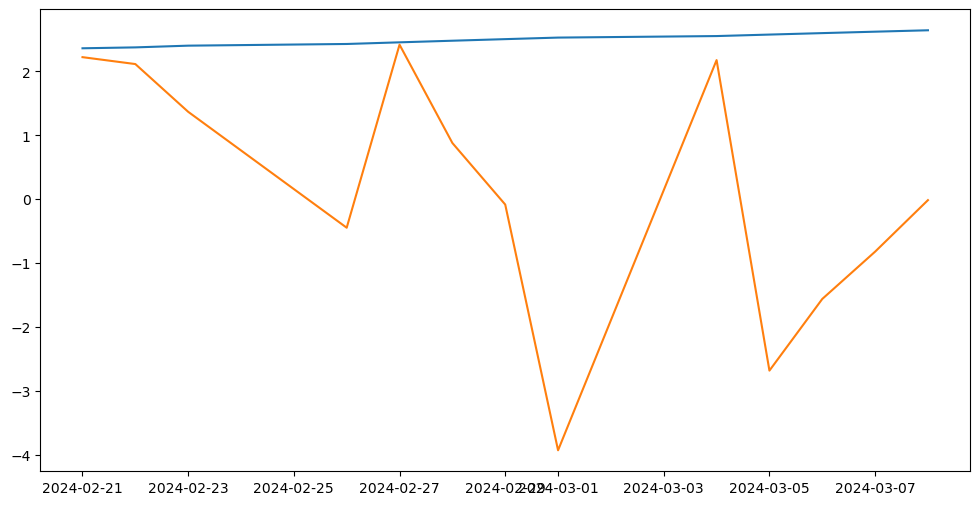

In [99]:
plt.figure(figsize=(12,6))
plt.plot(df_bmw['Date'],df_bmw['Vals'])
plt.plot(df['Date'].iloc[-13:],df['log_returns'].iloc[-13:])

In [79]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_result = adfuller(bmw_training_data['log_returns'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Interpretation
if adf_result[1] < 0.05:
    print("Log returns are stationary ✅")
else:
    print("Log returns are NOT stationary ⚠️ - Consider demeaning.")


ADF Statistic: -14.585416893184993
p-value: 4.3999821079896426e-27
Log returns are stationary ✅


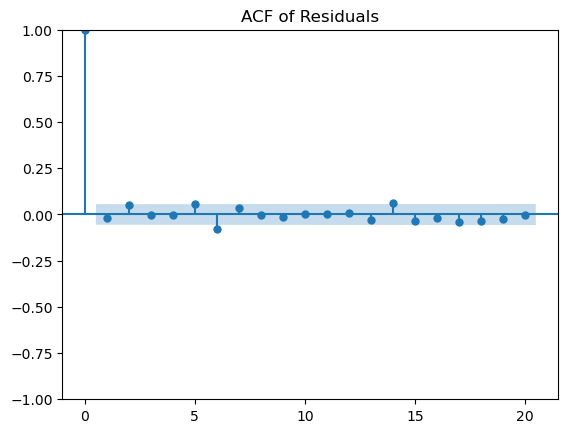

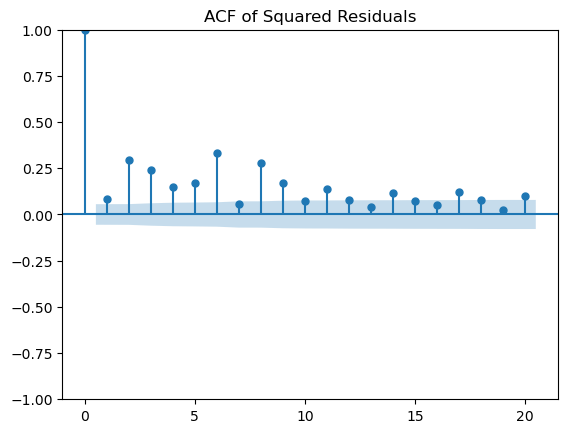

In [83]:

residuals=gjr_garch_vow_aic_bic.resid
# ACF of residuals (should be uncorrelated)
plot_acf(residuals, lags=20)
plt.title("ACF of Residuals")
plt.show()

# ACF of squared residuals (should be flat if GARCH captured volatility well)
plot_acf(residuals**2, lags=20)
plt.title("ACF of Squared Residuals")
plt.show()